In [ ]:
# STEP 1: INSTALL LIBRARIES (Only run once)
!pip install transformers datasets torch scikit-learn huggingface_hub wandb

In [ ]:
!pip install datasets

Data Preprocessing and Dataset Preparation

In [ ]:
!pip install transformers datasets torch scikit-learn huggingface_hub wandb

import pandas as pd
import re
from datasets import Dataset

# Load dataset
file_path = 'mytextdata.csv'
df = pd.read_csv(file_path)

# Text cleaning
def clean_text(text):
    return re.sub(r'[^\w\s]', '', text)

df['Text'] = df['Text'].apply(clean_text)

# 🚩 Rename "Label" column to "labels" and convert labels to integers
label_to_id = {label: idx for idx, label in enumerate(df['Label'].unique())}
df['labels'] = df['Label'].map(label_to_id)

# Hugging Face dataset conversion
dataset = Dataset.from_pandas(df)
print(dataset[:5])

{'Audio File': ['sph_per154_agreeableness.wav', 'sph_per261_neuroticism.wav', 'sph_per258_openness.wav', 'sph_per319_agreeableness.wav', 'sph_per276_neuroticism.wav'], 'Text': ['সলর পযনলর দম করমশই কমছ এটর সঠক বযবহর আমদর নশচত কর একসথ সমনর দক আগত হব', 'আম কন কজই ঠকমত মননবশ করত পরছ ন', 'শভর মঘর ভড তমর সব ইচছ ওড', 'বসতবমখ সদধনত জনকলযণমখ সরকর এব সরকর পরধনর আনতরক আর নরলস পরচষট ততই বলদশ আজ একট উননত সফল গরবত রষটর রপনতরত হচছ', 'মঝ মঝ মন হয মতয ক শরয নয'], 'Label': ['agreeableness', 'neuroticism', 'openness', 'agreeableness', 'neuroticism'], 'labels': [0, 1, 2, 0, 1]}


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

model_name = "sagorsarker/bangla-bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_to_id)
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
MAX_LENGTH = 128

def tokenize_function(examples):
    return tokenizer(
        examples['Text'],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/1750 [00:00<?, ? examples/s]

In [ ]:
# Consistent train-test split
split_dataset = tokenized_datasets.train_test_split(test_size=0.1)
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']


In [ ]:
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback


training_args = TrainingArguments(
    output_dir='./results',
    logging_dir='./logs',
    logging_steps=500,
    save_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    learning_rate=2e-5,
    eval_steps=500,
    report_to="wandb"
)

# Set up EarlyStopping callback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)


In [ ]:
trainer.train()

Step,Training Loss
500,0.456100


TrainOutput(global_step=591, training_loss=0.38689886979040156, metrics={'train_runtime': 200.4157, 'train_samples_per_second': 23.576, 'train_steps_per_second': 2.949, 'total_flos': 310808305785600.0, 'train_loss': 0.38689886979040156, 'epoch': 3.0})

Evaluate the model

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.028053289279341698, 'eval_runtime': 1.2146, 'eval_samples_per_second': 144.079, 'eval_steps_per_second': 18.113, 'epoch': 3.0}


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Generate predictions
predictions, labels, _ = trainer.predict(test_dataset)
predicted_labels = predictions.argmax(axis=1)

# Metrics
accuracy = accuracy_score(labels, predicted_labels)
f1 = f1_score(labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1-Score: {f1}")


Accuracy: 0.9942857142857143
F1-Score: 0.9942878604963112


In [ ]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Get model predictions on the test dataset
predictions, true_labels, _ = trainer.predict(test_dataset)

# Convert logits to probabilities using softmax
probabilities = torch.softmax(torch.tensor(predictions), dim=-1).numpy()

In [ ]:
num_labels = probabilities.shape[1]
print(f"Number of labels: {num_labels}")

Number of labels: 5


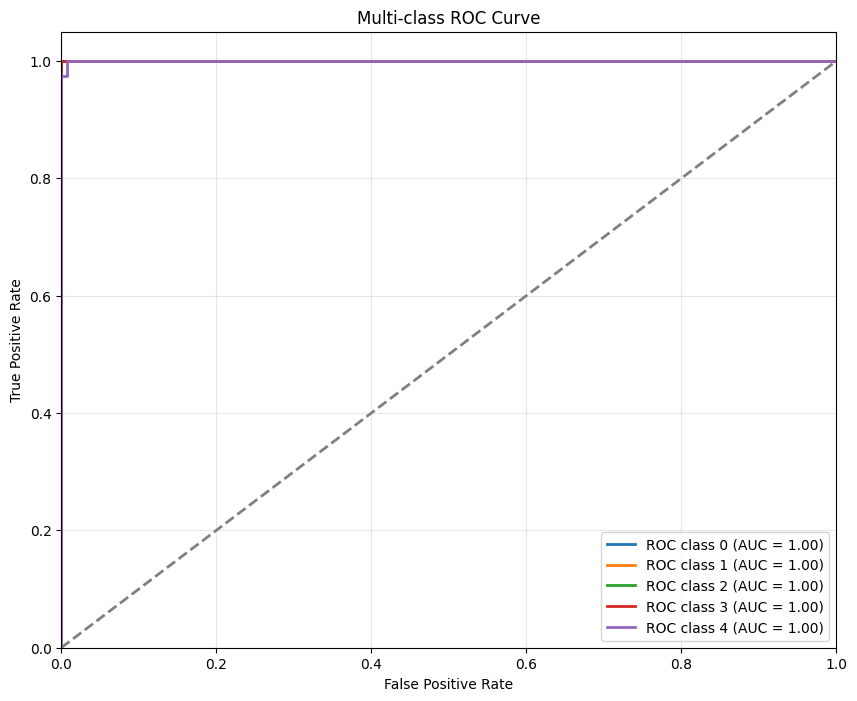

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

if num_labels > 2:
    # Convert labels to one-hot encoding
    true_labels_bin = label_binarize(true_labels, classes=np.arange(num_labels))

    plt.figure(figsize=(10,8))

    for i in range(num_labels):
        fpr, tpr, _ = roc_curve(true_labels_bin[:, i], probabilities[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'ROC class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get model predictions on the test dataset
predictions, true_labels, _ = trainer.predict(test_dataset)

# Convert logits to predicted class labels
predicted_labels = predictions.argmax(axis=1)

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix
print(cm)

[[31  0  0  0  0]
 [ 0 50  0  0  0]
 [ 0  0 35  0  0]
 [ 0  0  0 21  0]
 [ 0  0  1  0 37]]


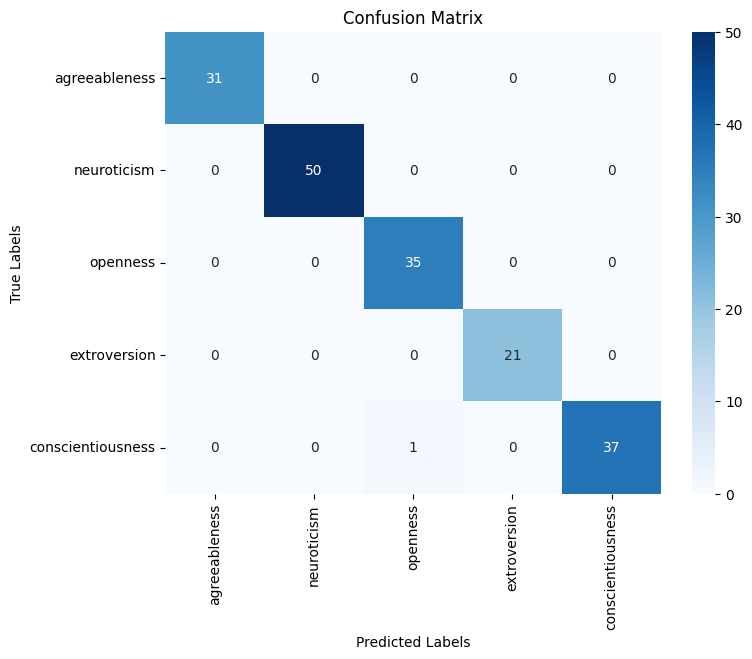

In [ ]:
# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Get model predictions on the test dataset
predictions, true_labels, _ = trainer.predict(test_dataset)

# Convert logits to predicted class labels
predicted_labels = predictions.argmax(axis=1)


In [ ]:
# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=label_to_id.keys(), output_dict=True)

# Convert the report into a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Display the table
print(report_df)


                   precision    recall  f1-score     support
agreeableness       1.000000  1.000000  1.000000   31.000000
neuroticism         1.000000  1.000000  1.000000   50.000000
openness            0.972222  1.000000  0.985915   35.000000
extroversion        1.000000  1.000000  1.000000   21.000000
conscientiousness   1.000000  0.973684  0.986667   38.000000
accuracy            0.994286  0.994286  0.994286    0.994286
macro avg           0.994444  0.994737  0.994516  175.000000
weighted avg        0.994444  0.994286  0.994288  175.000000


In [ ]:
model.save_pretrained('./trained_model')
tokenizer.save_pretrained('./trained_model')

Saving vocabulary to ./trained_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to ./trained_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to ./trained_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to ./trained_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to ./trained_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to ./trained_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to ./trained_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to ./trai

('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/vocab.txt',
 './trained_model/added_tokens.json')